In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

In [2]:
df = pd.read_csv("seismic-bumps.csv")

In [3]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## Feature preprocessing (light)

In [4]:
#remove useless variables from the dataset
column2drop = ['seismoacoustic', 'gdenergy', 'gdpuls', 'hazard','nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy']
df.drop(column2drop, axis=1, inplace=True)

In [5]:
df.head()

,seismic,shift,genergy,gpuls,nbumps,class
0,a,N,15180,48,0,0
1,a,N,14720,33,1,0
2,a,N,8050,30,0,0
3,a,N,28820,171,1,0
4,a,N,12640,57,0,0


In [6]:
###### Lecture Pipeline ######
# you can/have to modify the order for your project,
# e.g. hyperparameter tuning before evaluating a decision tree

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

##### Decision Tree Visualization ###
from sklearn import tree # export_graphviz() method
import pydotplus # viz stuff
from IPython.display import Image # viz stuff
####################################

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

In [7]:
# Printing categorical first 5 values before pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  ['a' 'a' 'a' 'a' 'a']
shift's first 5 values:  ['N' 'N' 'N' 'N' 'N']


In [8]:
# Transform categorical attributes ('seismic' and 'shift') into numerical ones 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['seismic'] = le.fit_transform(df['seismic'])
df['shift'] = le.fit_transform(df['shift'])

In [9]:
# Printing categorical first 5 values after pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  [0 0 0 0 0]
shift's first 5 values:  [0 0 0 0 0]


## APPLYING CLASSIFICATION

In [10]:
# Spliting dataset into training-set and test-set using HOLD-OUT method

attributes = [col for col in df.columns if col != 'class']
X = df[attributes].values
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

In [11]:
# Printing the shape of dataset, training-set and test-set ([number_of_rows], [number_of_columns])

df.shape, X_train.shape, X_test.shape

((2584, 6), (1938, 5), (517, 5))

In [12]:
ros = RandomOverSampler(random_state=942)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1811, 1: 1811})


In [13]:
# Applying the classification algorithm with some parameters

clf = DecisionTreeClassifier(criterion='gini',
                             max_leaf_nodes = 9,
                             min_samples_split=20,
                             min_samples_leaf=10,
                            )

clf.fit(X_res, y_res)

DecisionTreeClassifier(max_leaf_nodes=9, min_samples_leaf=10,
                       min_samples_split=20)

In [14]:
param_list = {'max_depth': [None] + [2, 3, 4],
             'min_samples_split': [2, 5, 10, 20],
             'min_samples_leaf': [1, 5, 10, 20]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='recall')
grid_search.fit(X, y)

res = grid_search.cv_results_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.206 (std: 0.353)
Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}



In [15]:
# Priting the attibutes in order of importance according to the classification algorithm applied

imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
imp_dict

{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'nbumps': 0.5471476981354836,
 'gpuls': 0.38208376585810117,
 'genergy': 0.07076853600641543,
 'seismic': 0.0,
 'shift': 0.0}

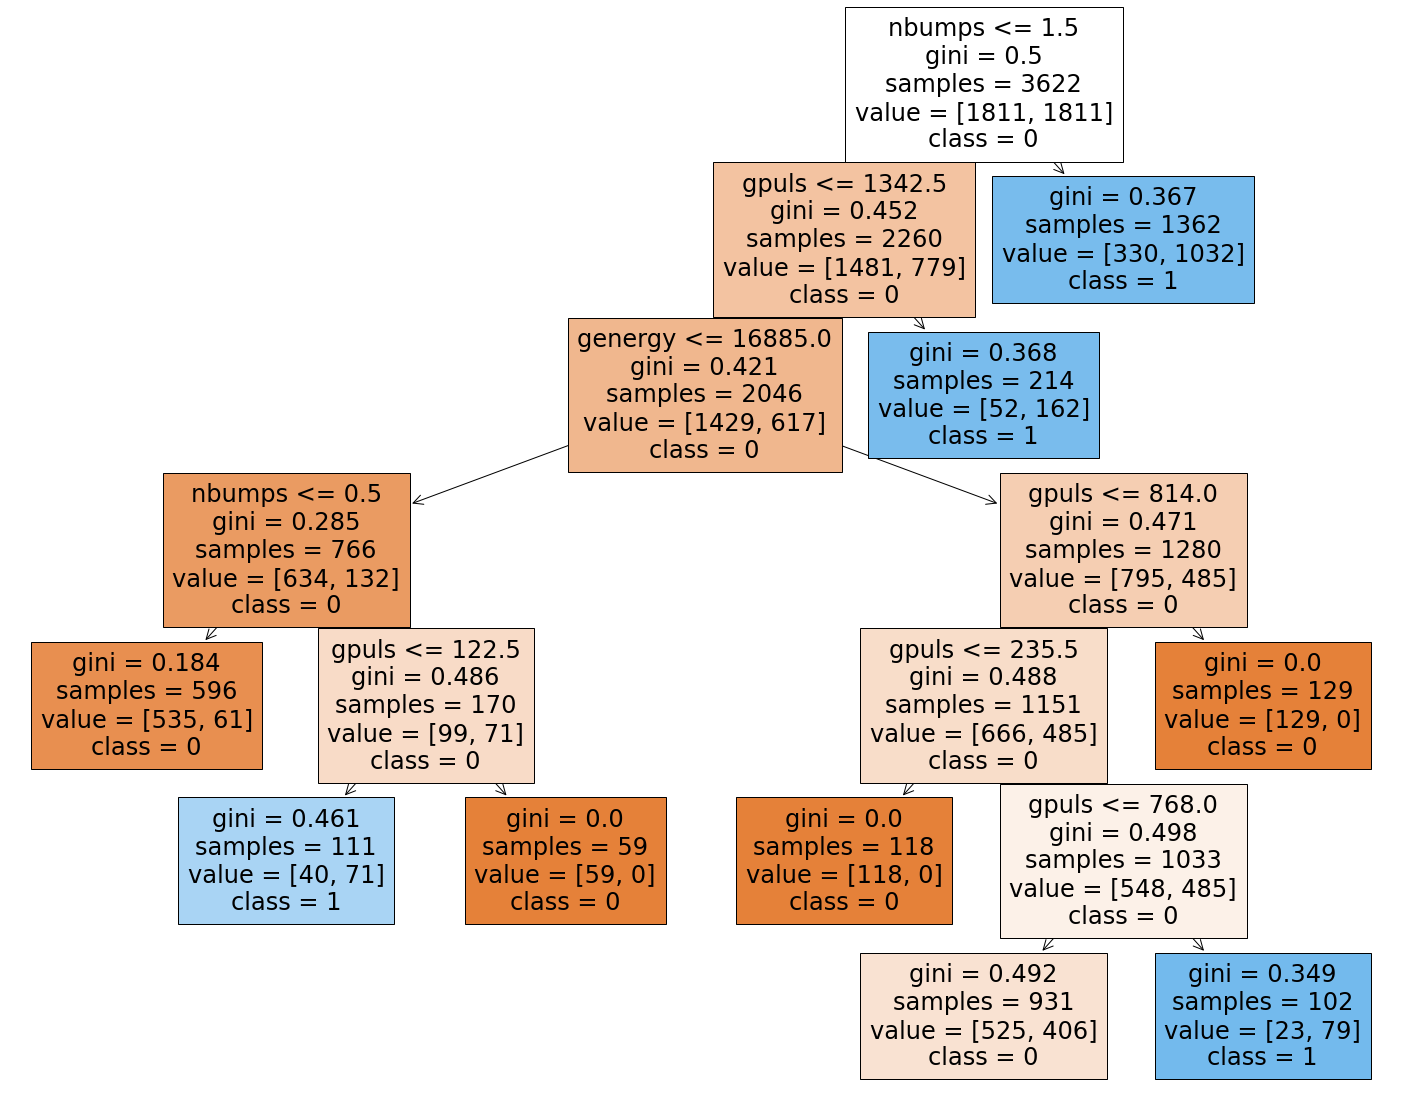

In [16]:
# Plotting the entire Decision Tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True)

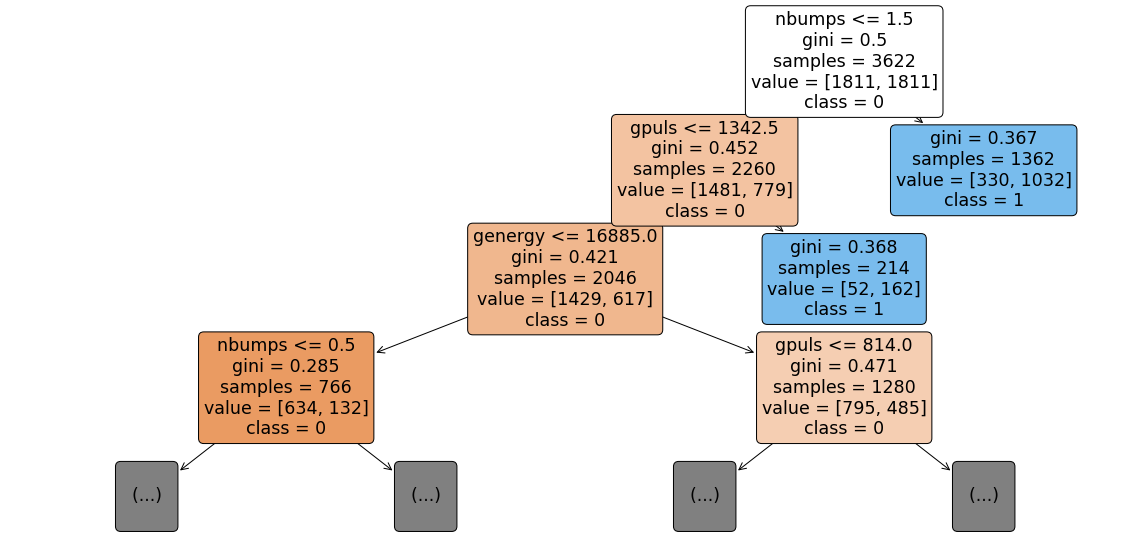

In [17]:
# Plotting only the first 3 levels of the DT

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True, 
                   rounded=True,
                   max_depth=3)

## MODEL EVALUATION

In [18]:
# Applying the model to the train-set and test-set

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict( X_test )

In [19]:
# Printing the 'Accuracy' and 'F1' values for evaluate the quality of the prediction
# F1 [f1 score of negative class, f1 score positive class]

print('TRAINING-SET')
print('Accuracy', accuracy_score(y_train, y_train_pred))
print('F1', f1_score(y_train, y_train_pred, average=None),'\n')

print('TEST-SET')
print('Accuracy', accuracy_score(y_test, y_test_pred))
print('F1', f1_score(y_test, y_test_pred, average=None))

TRAINING-SET
Accuracy 0.7538699690402477
F1 [0.85135556 0.28485757] 

TEST-SET
Accuracy 0.7949709864603481
F1 [0.87954545 0.31168831]


In [20]:
# Printing other evaluation indences

print('TRAINING-SET')
print( classification_report(y_train, y_train_pred), '\n\n' )

print('TEST-SET')
print( classification_report(y_test, y_test_pred) )

TRAINING-SET
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1811
           1       0.18      0.75      0.28       127

    accuracy                           0.75      1938
   macro avg       0.58      0.75      0.57      1938
weighted avg       0.92      0.75      0.81      1938
 


TEST-SET
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       483
           1       0.20      0.71      0.31        34

    accuracy                           0.79       517
   macro avg       0.59      0.75      0.60       517
weighted avg       0.92      0.79      0.84       517



In [21]:
# Printing of confusion_matrix as seen in the lecture

cf1 = confusion_matrix(y_train, y_train_pred, labels=[1,0])
cf2 = confusion_matrix(y_test, y_test_pred, labels=[1,0])


print('TRAINING-SET')
print( cf1, '\n')
print('TEST-SET')
print( cf2 )


TRAINING-SET
[[  95   32]
 [ 445 1366]] 

TEST-SET
[[ 24  10]
 [ 96 387]]


In [22]:
# TP, FN, FP, TN
print('TRAINING-SET: ', cf1[0][0], cf1[0][1], cf1[1][0], cf1[1][1])
print('TEST-SET:     ', cf2[0][0], cf2[0][1], cf2[1][0], cf2[1][1])

TRAINING-SET:  95 32 445 1366
TEST-SET:      24 10 96 387


In [23]:
cf1 = confusion_matrix(y_train, y_train_pred, labels=[1,0], normalize='all')
cf2 = confusion_matrix(y_train, y_train_pred, labels=[1,0], normalize='all')

print('TRAINING-SET')
print( cf1, '\n')
print('TEST-SET')
print( cf2 )

TRAINING-SET
[[0.04901961 0.01651187]
 [0.22961816 0.70485036]] 

TEST-SET
[[0.04901961 0.01651187]
 [0.22961816 0.70485036]]


In [24]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

y_score = clf.predict_proba(X_test)
y_score[:6]

array([[0.24229075, 0.75770925],
       [0.56390977, 0.43609023],
       [0.89765101, 0.10234899],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.89765101, 0.10234899]])

In [25]:
# Printing of AUC value (aka Area under the ROC)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7343198148824748


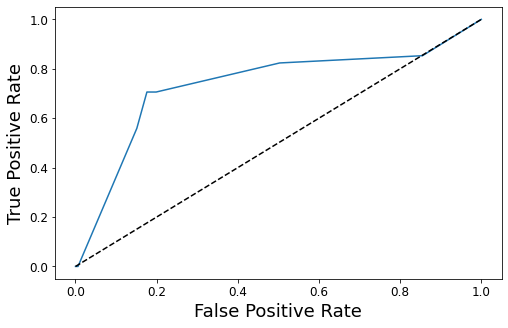

In [238]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [55]:
prec, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [56]:
from sklearn.metrics import PrecisionRecallDisplay

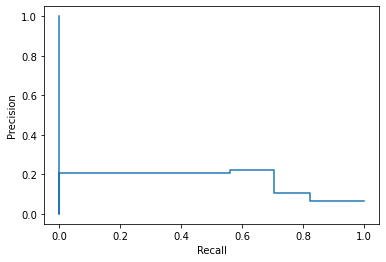

In [57]:
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [58]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import matplotlib.pyplot as plt

In [59]:
pr_auc= auc(recall, prec)
print(pr_auc)

0.11906661192352876


In [60]:
from sklearn import metrics

AUC_list = []

def tree_training(max_leaf_nodes, X_res, y_res, X_val, y_val):
    model_tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, class_weight='balanced')
    model_tree.fit(X_res, y_res)
    
    y_train_pred = model_tree.predict(X_res)
    y_val_pred = model_tree.predict(X_val)

    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc= auc(recall, precision)
    auc_train = metrics.pr_auc(y_res, y_train_pred)
    auc_valid = metrics.pr_auc(y_val, y_val_pred)
    
    #print("Nodes:{}, Train_AUC:{:.4f}, Test_AUC:{:.4f}, Diff:{:.4f}".format(max_leaf_nodes,
    #                                                                 auc_train,
    #                                                                 auc_valid,
    #                                                                 auc_train-auc_valid))
    AUC_list.append( (auc_train, auc_valid) )
          


# Run few iterations to find which max_tree_nodes works best
for i in range(2, 51):
    tree_training(i, X_res, y_res, X_val, y_val)

plt.figure(figsize=(8,5))
plt.plot(range(2, len(AUC_list)+2), AUC_list, marker='*')
plt.xlabel('Number of nodes', fontsize=18)
plt.ylabel('AUC', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Training', 'Validation'], loc='best', fontsize=14)
plt.show()

AttributeError: module 'sklearn.metrics' has no attribute 'pr_auc'

In [70]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

scores = cross_val_score(clf, X_res, y_res, cv=10, scoring='recall')

scores.mean(), scores.std()

(0.9063663797537806, 0.047619634290653745)

In [31]:
clfk = KNeighborsClassifier(n_neighbors=5)
clfk.fit(X_res, y_res)

KNeighborsClassifier()

In [222]:
#prediction
yk_pred = clfk.predict(X_test)

In [224]:
print('Accuracy', accuracy_score(y_test, yk_pred))
print('F1', f1_score(y_test, yk_pred, average=None))

Accuracy 0.7770618556701031
F1 [0.87288758 0.09424084]


In [225]:
# Printing other evaluation indences
print( classification_report(y_test, yk_pred) )

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       725
           1       0.06      0.18      0.09        51

    accuracy                           0.78       776
   macro avg       0.50      0.50      0.48       776
weighted avg       0.88      0.78      0.82       776



In [226]:
# Applying the model to the test-set (default threshold = 0.5)
yk_pred = clfk.predict( X_test )
yk_pred[:5]

array([0, 1, 0, 0, 0])

In [227]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

yk_score = clfk.predict_proba(X_test)
yk_score[:6]

array([[0.8, 0.2],
       [0.2, 0.8],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [228]:
# Printing of AUC value (aka Area under the ROC)
fpr, tpr, th = roc_curve(y_test, yk_score[:,1])

In [229]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5284110885733604


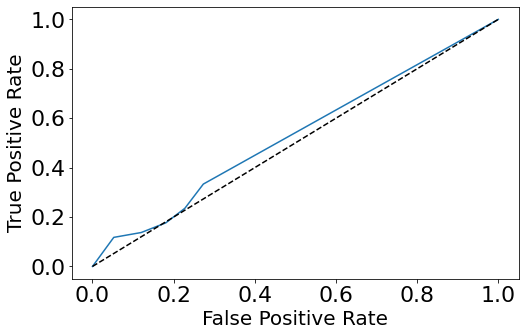

In [230]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [231]:
cf = confusion_matrix(y_test, yk_pred, labels=[1,0])
cf

array([[  9,  42],
       [131, 594]])